<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [2]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16331842238658196218
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13896777728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18283725137384424744
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Loading

Load images and respective labels

In [4]:
base_dir = r"C:\Users\Blix\Downloads\Data"

In [5]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [37]:
image_height = 128
image_width = 128
batch_size = 32
seed = 42 # For reproducibility

In [38]:
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical', # Your labels are one-hot encoded
    image_size=(image_height, image_width),
    interpolation='bicubic', # or 'bilinear', 'nearest'
    batch_size=batch_size,
    shuffle=True, # Shuffle training data
    seed=seed,
    validation_split=0.3, # 30% for validation/test combined
    subset='training'
)

print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    seed=seed,
    validation_split=0.3,
    subset='validation'
)

Loading training data...
Found 81410 files belonging to 16 classes.
Using 56987 files for training.
Loading validation data...
Found 81410 files belonging to 16 classes.
Using 24423 files for validation.


In [ ]:
'''images = []
labels = []
for style in styles:
    style_dir = os.path.join(base_dir, style)
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        try:
            img = Image.open(image_path).convert('RGB') # Load image and convert to RGB
            img = img.resize((image_height, image_width)) # Resize images to a consistent size
            img_array = np.array(img)
            images.append(img_array)
            labels.append(style) # Use the style name as the label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")'''

In [39]:
print(f"Detected class names: {train_ds.class_names}")

Detected class names: ['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [40]:
all_image_paths = []
all_labels = []

## Data Split

In [41]:
grouped_styles = [
    'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [42]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [43]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)

In [44]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize
    num_classes = len(grouped_styles) # Use the count of your grouped styles
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [45]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

## Model Training

In [ ]:
model = tf.keras.Sequential([
    # First block with batch normalization
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    
    # Second block
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.3),
    
    # Third block
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.3),
    
    # Fourth block
    tf.keras.layers.Conv2D(512, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    
    # Dense layers
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(styles), activation='softmax')
])

In [49]:
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 128, 128, 64)     

In [50]:
# Initialize starting learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing = 0.1),
    metrics=['accuracy']
)

In [51]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,
)

In [52]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=0.0001,
    verbose=1
)

In [53]:
# Fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,  # Use the validation generator
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    batch_size= batch_size
)

Epoch 1/1000
  84/1781 [>.............................] - ETA: 1:41 - loss: 3.2617 - accuracy: 0.1946

KeyboardInterrupt: 

## Model Evaluation

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

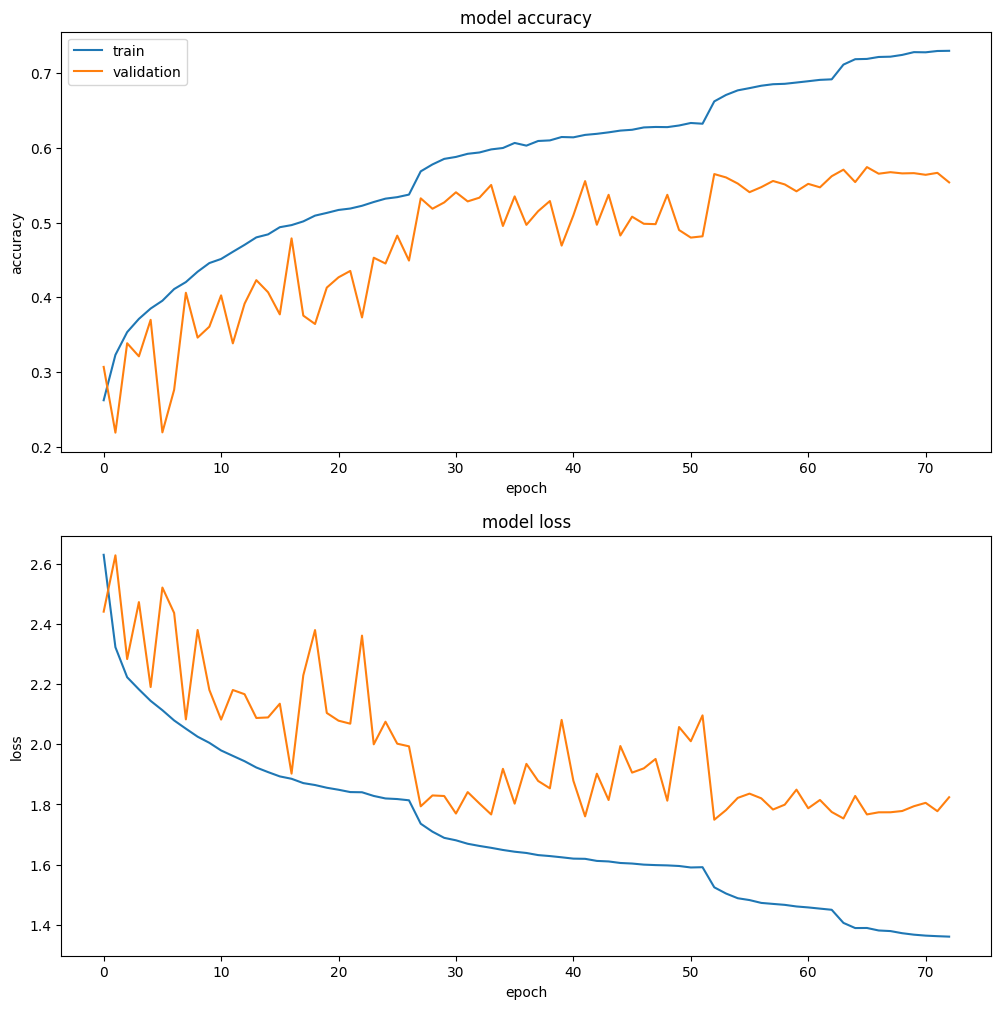

In [ ]:
# Plot Loss Graphs
plot_history(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)

382/382 [==============================] - 7s 18ms/step - loss: 1.7405 - accuracy: 0.5709


In [ ]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.7405
Test Accuracy: 0.5709


In [ ]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('style_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
model.save('style_classification_model.h5')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmppx4tpeuq\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmppx4tpeuq\assets


In [ ]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=styles))

382/382 [==============================] - 7s 17ms/step
                       precision    recall  f1-score   support

   Art_Nouveau_Modern       0.60      0.37      0.46       643
              Baroque       0.60      0.43      0.50       628
 Color_Field_Painting       0.65      0.64      0.65       257
               Cubism       0.65      0.49      0.56       376
        Expressionism       0.40      0.58      0.47      1378
              Fauvism       0.34      0.17      0.23       129
        Impressionism       0.62      0.81      0.70      3058
           Minimalism       0.52      0.70      0.60       206
Naive_Art_Primitivism       0.62      0.31      0.41       365
              Pop_Art       0.49      0.38      0.43       221
              Realism       0.52      0.49      0.51      1690
          Renaissance       0.73      0.69      0.71      1024
               Rococo       0.64      0.42      0.51       314
          Romanticism       0.54      0.41      0.47      103